# データの取得方法

In [ ]:
import quandl
data = quandl.get('NIKKEI/INDEX')

In [4]:
data[:5]

,Open Price,High Price,Low Price,Close Price
Date,,,,
1950-01-04,NaN,NaN,0.0,108.56
1950-01-05,NaN,NaN,0.0,105.54
1950-01-06,NaN,NaN,0.0,102.64
1950-01-09,NaN,NaN,0.0,102.78
1950-01-10,NaN,NaN,0.0,101.36


In [30]:
data_normal = (data['Close Price'])
data_normal[-10:-1]

Date
2017-07-14    20118.86
2017-07-18    19999.91
2017-07-19    20020.86
2017-07-20    20144.59
2017-07-21    20099.75
2017-07-24    19975.67
2017-07-25    19955.20
2017-07-26    20050.16
2017-07-27    20079.64
Name: Close Price, dtype: float64

# データの用い方

In [34]:
import numpy as np
import pandas as pd
from scipy import stats
from pandas.core import datetools
# grapgh plotting 
from matplotlib import pylab as plt
import seaborn as sns
%matplotlib inline

# settings graph size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6

# model 
import statsmodels.api as sm

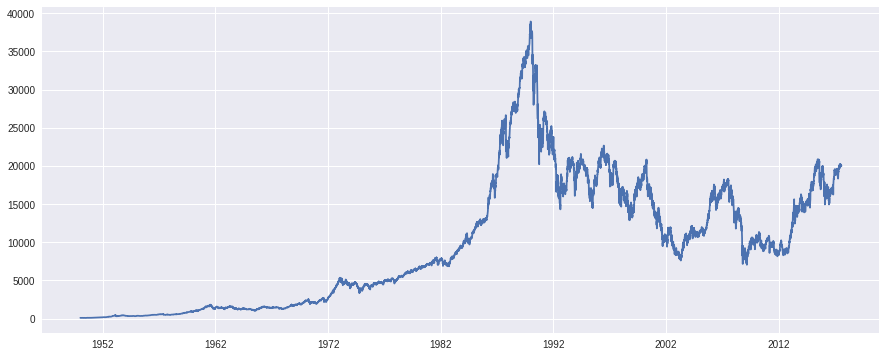

In [36]:
plt.plot(data_normal)

In [60]:
# ARIMA model prediction ... (This is self thought (not automatically))
diff = data_normal - data_normal.shift()
diff = diff.dropna()
diff.head()

Date
1950-01-05   -3.02
1950-01-06   -2.90
1950-01-09    0.14
1950-01-10   -1.42
1950-01-11   -2.00
Name: Close Price, dtype: float64

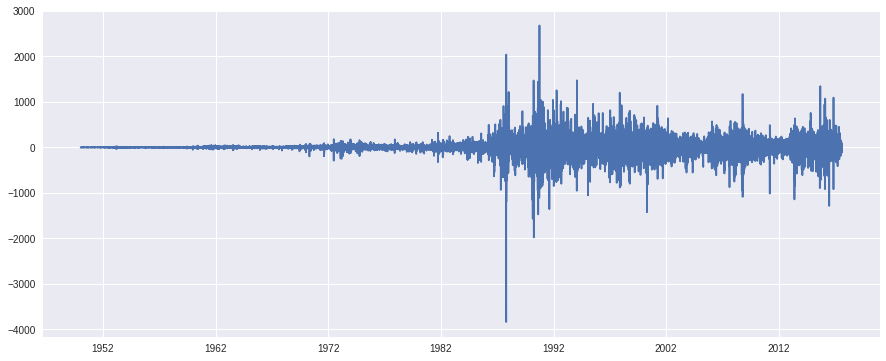

In [61]:
# difference plot 
plt.plot(diff)

In [ ]:
# automatically ARIMA prediction function (using AIC)
resDiff = sm.tsa.arma_order_select_ic(diff, ic='aic', trend='nc')
# few Times ...(orz...)

In [65]:
resDiff 
# search min
resDiff['aic_min_order']

(2, 2)

In [75]:
# we found x = x, y= y autopmatically
from statsmodels.tsa.arima_model import ARIMA
ARIMAx_1_y = ARIMA(data_normal, 
                  order=(resDiff['aic_min_order'][0], 1,
                  resDiff['aic_min_order'][1])).fit(dist=False)
# AR = resDiff[...][0] / I = 1 / MA = resDiff[...][1]
ARIMAx_1_y.params

const                  1.181341
ar.L1.D.Close Price   -0.149589
ar.L2.D.Close Price   -0.497140
ma.L1.D.Close Price    0.152421
ma.L2.D.Close Price    0.440712
dtype: float64

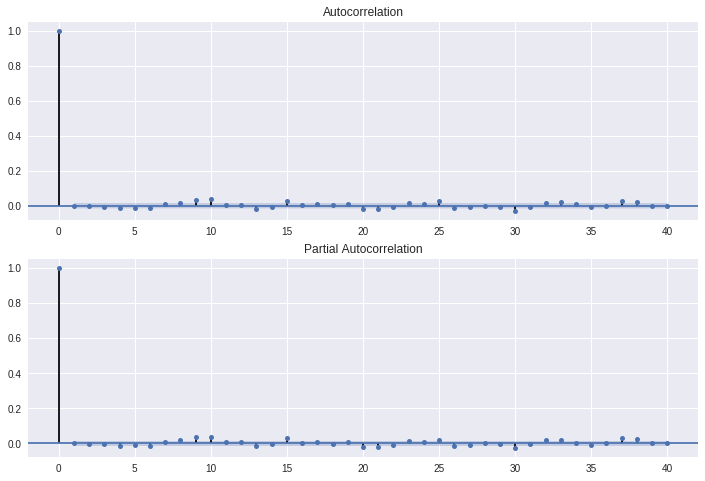

In [76]:
# check Residual error (... I think this is "White noise")
# this is not Arima ... (Periodicity remained)
resid = ARIMAx_1_y.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)

# ok? 

In [ ]:
# We test SARIMA_model

In [78]:
# predict SARIMA model  by  myself (not automatically) 
import statsmodels.api as sm

SARIMAx_1_y_111 = sm.tsa.SARIMAX(data_normal, 
                                 order=(2,1,2),seasonal_order=(1,1,1,12)).fit()
# order ... from ARIMA model // seasonal_order ... 1 1 1 ... ?  
print(SARIMAx_1_y_111.summary())

# maybe use "Box-Jenkins method" ...
# https://github.com/statsmodels/statsmodels/issues/3620 for error

                                 Statespace Model Results                                 
Dep. Variable:                        Close Price   No. Observations:                16806
Model:             SARIMAX(2, 1, 2)x(1, 1, 1, 12)   Log Likelihood             -109764.666
Date:                            Mon, 31 Jul 2017   AIC                         219543.332
Time:                                    15:57:31   BIC                         219597.439
Sample:                                01-04-1950   HQIC                        219561.184
                                     - 07-28-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9776   7266.722     -0.000      1.000   -1.42e+04    1.42e+04
ar.L2          0.0082   7271.692   

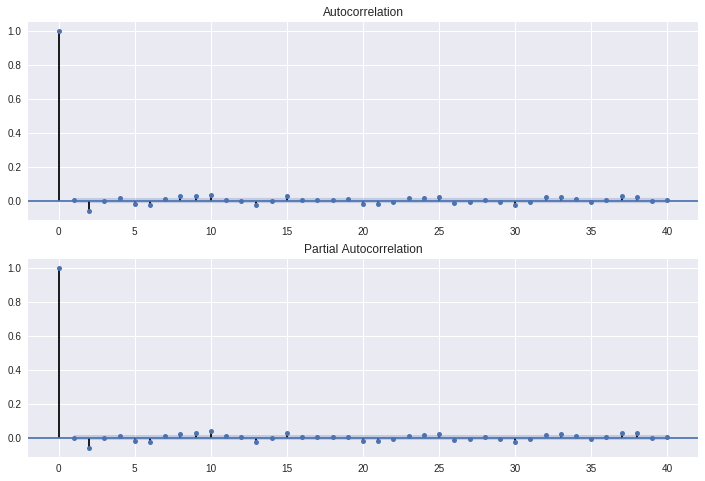

In [79]:
# check Residual error
residSARIMA = SARIMAx_1_y_111.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residSARIMA.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residSARIMA, lags=40, ax=ax2)

In [88]:
# prediction
pred = SARIMAx_1_y_111.predict('2017-07-10', '2017-07-27')
print(pred)

Date
2017-07-10    19933.446617
2017-07-11    20079.346345
2017-07-12    20208.299539
2017-07-13    20094.335716
2017-07-14    20104.769382
2017-07-18    20116.749463
2017-07-19    20001.906573
2017-07-20    20008.243273
2017-07-21    20155.316645
2017-07-24    20097.340278
2017-07-25    19978.178767
2017-07-26    19953.289529
2017-07-27    20055.638026
dtype: float64


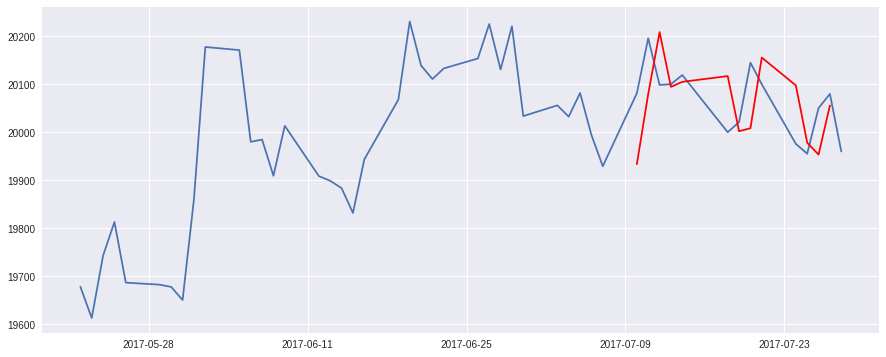

In [92]:
# plot real data and predict data 
plt.plot(data_normal[:-50:-1])
plt.plot(pred, "r")